# Jigsaw Near Infra Red Aerial Photography

### raster vs vector data useful intro
https://carpentries-incubator.github.io/geospatial-python/aio/index.html

libraries for raster data
- rasterio
- rioxarray

libraries for vector data
- geopandas
- geocube

### overview of essential geospatial python libraries
https://medium.com/@chrieke/essential-geospatial-python-libraries-5d82fcc38731

### crop raster with vector

- earthpy
- rasterio
- cartopy

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/crop-raster-data-with-shapefile-in-python/

https://www.earthdatascience.org/workshops/gis-open-source-python/crop-raster-data-in-python/

## Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

import glob

import earthpy as et 
import earthpy.spatial as es 
import earthpy.plot as ep #to plot np array of RGB pixel numbers
import cartopy as cp

import mplleaflet
import folium
import fiona
import pyproj
import contextily
import shapely as shp

import rasterio
from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 

from rasterio.mask import mask

#check correct environment is being used: parkprov
print(sys.executable)

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Load lookup_rd_gdn

lookup_rd_gdn.csv is a lookup table derived in ppp06 in which each roadside garden polygon toid is linked with a residential dwelling building shape toid by the INSPIREID of the land registry land parcel that their representative points lie within. There are duplicates in this, multiple buildings and gardens associated with the same land parcel. Put this down to flats, new developments of housing estates, splitting of a single dwelling into multiple residences. 

In [2]:
#drop index column and specify to read toids as strings
#they have been saved with the leading zeroes preserved, but pandas will drop leading zeroes by default
#and read in as int
lookup_rd_gdn = pd.read_csv("../data/lookup_rd_gdn.csv",
                           dtype={'INSPIREID': object, 'rd_poly_toid': object, 'gdn_poly_toid': object}
                           ).drop(['Unnamed: 0'], axis = 1)
#forgot to not write the index column

In [3]:
lookup_rd_gdn.columns

Index(['INSPIREID', 'rd_poly_toid', 'gdn_poly_toid'], dtype='object')

In [4]:
lookup_rd_gdn.dtypes

INSPIREID        object
rd_poly_toid     object
gdn_poly_toid    object
dtype: object

In [5]:
lookup_rd_gdn.head()

,INSPIREID,rd_poly_toid,gdn_poly_toid
0,35014222,0001000003513013,5000005125902450
1,35014259,0001000003513012,1000001778713698
2,35014286,0001000003513011,1000001778713632
3,35014325,0001000003513010,1000001778714168
4,35014359,0001000003513009,1000001778713624


## Load Topographic Area TQ1980

I created this in QGIS by selecting all the polygons in the TA layer that intersected with the TQ1980 raster layer, by drawing a square around it.

In [3]:
path = "../data/eTopoArea_1980/eTopoArea_1980.gpkg"
for layername in fiona.listlayers(path):
    with fiona.open(path, layer=layername) as src:
        print(layername, len(src))
        
ta = gpd.read_file(path)

NameError: name 'fiona' is not defined

In [2]:
ta.plot(color='green')

NameError: name 'ta' is not defined

## Load Near Infra Red Aerial Photography TQ1980

See ppp03 for full details

In [8]:
#get path for TQ1980 AP RGBI
rgbiTQ1980 = '../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif'


In [9]:
src = rasterio.open(rgbiTQ1980)
print("path: ", src.name, "\nmode: ", src.mode, "\nis closed?: ", src.closed
      , "\nband count: ", src.count, "\nshape: ", src.shape)

path:  ../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif 
mode:  r 
is closed?:  False 
band count:  3 
shape:  (2000, 2000)


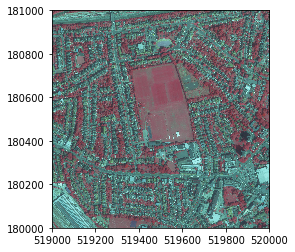

In [10]:
#make sure 'from rasterio import plot' is run ffs
plot.show(src)

## Filter ta for my list of gdn_poly_toid

In [11]:
#remove duplicates and create list of garden toids
gdn_toid_list = lookup_rd_gdn['gdn_poly_toid'].drop_duplicates().tolist()
#filter ta for these toids
gdn = ta[ta['TOID'].isin(gdn_toid_list)]

In [12]:
print(gdn.shape)
gdn.head()

(1447, 23)


,id,OBJECTID,TOID,FeatureCode,Version,VersionDate,Theme,ThemeCount,CalculatedAreaValue,ChangeDate,ReasonForChange,ChangeHistoryCount,DescriptiveGroup,DescriptiveGroupCount,DescriptiveTerm,DescriptiveTermCount,Make,PhysicalLevel,PhysicalPresence,broken,SHAPE_Length,SHAPE_Area,geometry
13,643654,643654,1000001778783950,10053,7,2015-01-15T00:00:00,Land,1,696.324061,2015-01-11T00:00:00,Modified,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,448.361385,696.324061,"POLYGON ((519657.544 180045.614, 519659.195 18..."
74,644905,644905,1000001778708314,10053,6,2008-03-18T00:00:00,Land,1,18.536248,2007-10-11T00:00:00,Attributes,3,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,25.102976,18.536250,"POLYGON ((519787.350 180008.450, 519790.150 18..."
80,644935,644935,1000001778708000,10053,8,2019-11-04T00:00:00,Land,1,101.016240,2019-11-01T00:00:00,Modified,5,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,75.725109,100.950737,"POLYGON ((519573.550 179999.850, 519577.200 17..."
160,646641,646641,1000001778708002,10053,6,2008-03-18T00:00:00,Land,1,15.126256,2001-05-31T00:00:00,Reclassified,3,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,16.324930,15.126250,"POLYGON ((519590.900 180004.300, 519593.300 18..."
199,647747,647747,1000001778708315,10053,5,2008-03-18T00:00:00,Land,1,13.905024,2000-06-02T00:00:00,New,2,General Surface,1,Multi Surface,1.0,Multiple,50,None,false,15.427639,13.905000,"POLYGON ((519790.150 180001.300, 519794.750 18..."


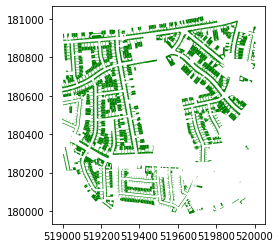

In [13]:
gdn.plot(color = 'green')

## Plot AP and TA

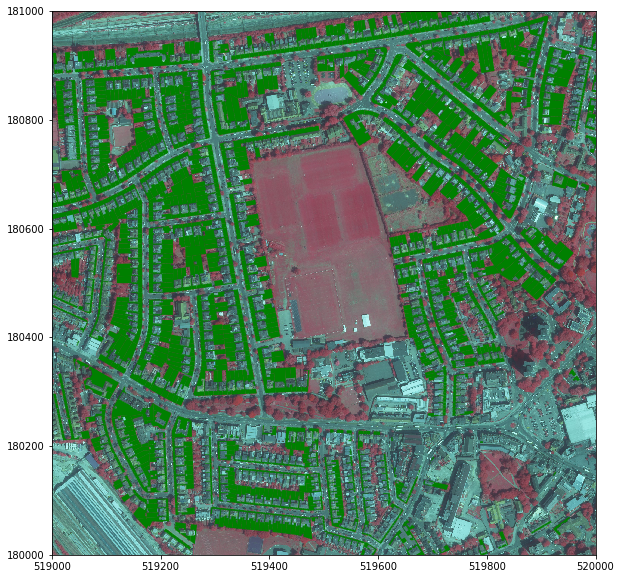

In [14]:
base = gdn.plot(figsize=(10,10),color = 'green')
plot.show(src, ax = base) #uses rasterio plot module

## Use rasterio.mask.mask to crop & mask raster with polygon

https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html
https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html

Method using cv2 and saving as png
https://stackoverflow.com/questions/15341538/numpy-opencv-2-how-do-i-crop-non-rectangular-region

## Function to apply to all gardens
- deduplicate garden polygons
- batch into all polygons per 1km grid
- open relevant 1km grid AP file
- for each AP 1km grid cut out all polygins that are entirely within it
- save with grid ref in name TQ1980
- how to collect edge case polygons?


In [15]:
rgbiTQ1980

'../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif'

In [17]:
#collect AP grid name for file
grid = rgbiTQ1980[-10:-4]


In [18]:
grid

'TQ1980'

Function jigsaw to cut up a single raster image into mulitple rater images, cropped to extent and masked by shapely polygons provided in a geoseries (geometry column of a geodataframe).

For each row
- make a single row geodataframe

In [19]:
def jigsaw(raster, gdf):
    
    #set meta data
    im_meta = raster.meta
    
    for i in np.arange(gdf.shape[0]):
        
        g = gdf.copy(deep=True).iloc[i:i+1] #create single row gdf from gdf
        
        #use rasterio.mask.mask from rasterio.mask import mask must be run
        #im: raster np array, im_transform: transform 
        im, im_transform = mask(dataset = raster
                                , shapes = g.geometry #assumes geometry column is named geometry
                                , crop = True #crop to North and East extent of image
                                , all_touched = True #include a pixel if it touches any of the shapes
                                , nodata = 255 #set nodata value for all RGB layers, 255 = white, 0 = black
                                , filled = True 
                               )
        #update meta data
        im_meta.update({"driver": "GTiff"
                        , "height": im.shape[1]
                        ,"width": im.shape[2]
                        ,"transform": im_transform})
        
        #create filename
        filename = "../jigsaw_output/rgbi_gardens/" + grid + "_" + g.TOID.iloc[0] + ".tif"
        
        #write to tif
        with rasterio.open(filename, mode = "w", **im_meta) as dest:
            dest.write(im)
        
        #plot.show(im)
        
    

### Run jigsaw on RGBI TQ1980 and gardens

In [20]:
jigsaw(raster = src, gdf = gdn)

# ARCHIVE